In [59]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

import seaborn as sns
sns.set_theme()

%config InlineBackend.figure_formats = ['pdf', 'svg']

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Utils


#### Построение порогов

* Сортируем по признаку, для которого ищем пороги
* Из срезки df[1:] вычитаем срезку df[:-1]
* Оставляем только те строки, где $y \ne 0$, там порог
* Делим значение признака на 2

In [4]:
# def compute_thresholds(df):
#     threshs = []
#     threshs_raveled = []
#     for i in range(df.shape[1] - 1):
#         df_sorted = df.sort_values(by=i).reset_index(drop='index')
#         tmp = df_sorted.rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0])[1:].reset_index()
#         ids = tmp[tmp.y != 0]['index'].values
#         threshs.append((df_sorted.iloc[ids, i].values + df_sorted.iloc[ids-1, i].values) / 2)
#         threshs_raveled += list(threshs[-1])
#     return threshs, threshs_raveled

def compute_thresholds(df):
    threshs = []
    threshs_raveled = []
    cur_neg = -1
    for i in range(df.shape[1] - 1):
        df_sorted = df.sort_values(by=i).reset_index(drop='index')

        for val in df_sorted[i]:
            if len(df_sorted[df_sorted[i] == val]['y'].unique()) > 1:
                y_ = df_sorted['y'].values
                y_[df_sorted[i] == val] = cur_neg
                df_sorted['y'] = y_
                cur_neg -= 1
        
        tmp = df_sorted.rolling(2).apply(lambda x: x.iloc[1] - x.iloc[0])[1:].reset_index()
        ids = tmp[(tmp.y != 0) & (tmp[i] != 0)]['index'].values
        threshs.append((df_sorted.iloc[ids, i].values + df_sorted.iloc[ids-1, i].values) / 2)
        threshs_raveled += list(threshs[-1])
    return threshs, threshs_raveled

### Построение булевой матрицы

In [5]:
from itertools import product
from tqdm import tqdm

def gen_bool_matrix(df: pd.DataFrame, threshs, threshs_raveled):

    unique_labels = sorted(df['y'].unique())
    n_threshs = []
    for i in range(len(threshs)):
        n_threshs += [i] * len(threshs[i])
    n_threshs += [-1]  # label

    df_stretched = df.iloc[:, n_threshs]
    classes = [df_stretched[df_stretched['y'] == y].drop(columns=['y']).values for y in unique_labels]
    res = []
    for c1, c2 in product(unique_labels, unique_labels):
        if c1 >= c2:
            continue
        for row1, row2 in product(classes[c1], classes[c2]):
            res.append(
                (row1 <= threshs_raveled) & (row2 > threshs_raveled) | \
                (row1 > threshs_raveled) & (row2 <= threshs_raveled)
            )
    return pd.DataFrame(res, columns=df_stretched.columns[:-1])

# Clean data

In [50]:
dataset_filename = "../csv/cleaned.csv"
df = pd.read_csv(dataset_filename)
df.columns = list(range(8)) + ['y']
df

,0,1,2,3,4,5,6,7,y
0,3,0,22.0,1,0,7.2500,0,0,0
1,1,1,38.0,1,0,71.2833,1,1,1
2,3,1,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,1
4,3,0,35.0,0,0,8.0500,0,0,0
...,...,...,...,...,...,...,...,...,...
884,2,0,27.0,0,0,13.0000,0,0,0
885,1,1,19.0,0,0,30.0000,6,0,1
886,3,1,28.0,1,2,23.4500,0,0,0
887,1,0,26.0,0,0,30.0000,1,1,1


In [51]:
df.drop_duplicates(inplace=True, subset=list(range(8)))
df

,0,1,2,3,4,5,6,7,y
0,3,0,22.0,1,0,7.2500,0,0,0
1,1,1,38.0,1,0,71.2833,1,1,1
2,3,1,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,1
4,3,0,35.0,0,0,8.0500,0,0,0
...,...,...,...,...,...,...,...,...,...
883,3,1,39.0,0,5,29.1250,0,2,0
885,1,1,19.0,0,0,30.0000,6,0,1
886,3,1,28.0,1,2,23.4500,0,0,0
887,1,0,26.0,0,0,30.0000,1,1,1


In [52]:
df.y.value_counts()

0    448
1    317
Name: y, dtype: int64

In [57]:
sampled = df.groupby('y', group_keys=False).apply(lambda x: x.sample(min(len(x), 120), random_state=42)).reset_index(drop='index')
print(f'{sampled.y.value_counts()=}')

sampled.y.value_counts()=0    120
1    120
Name: y, dtype: int64


In [58]:
sampled

,0,1,2,3,4,5,6,7,y
0,3,0,40.0,0,0,7.8958,0,0,0
1,3,0,35.0,0,0,7.1250,0,0,0
2,3,0,40.0,1,1,15.5000,0,2,0
3,2,0,25.0,1,2,41.5792,0,1,0
4,2,0,21.0,2,0,73.5000,0,0,0
...,...,...,...,...,...,...,...,...,...
235,2,0,34.0,0,0,13.0000,4,0,1
236,3,0,9.0,1,1,15.9000,0,0,1
237,2,1,35.0,0,0,21.0000,0,0,1
238,1,1,26.0,0,0,78.8500,0,0,1


In [59]:
threshs, threshs_raveled = compute_thresholds(sampled)

In [60]:
bool_matrix = gen_bool_matrix(sampled, threshs, threshs_raveled)#.sample(5)
# bool_matrix = bool_matrix.loc[:, (bool_matrix != 0).any(axis=0)]
bool_matrix

100%|██████████| 14400/14400 [00:01<00:00, 13645.78it/s]


,0,0,0,0,0,0,0,0,0,0,...,7,7,7,7,7,7,7,7,7,7
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14395,1,1,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14396,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
14397,1,1,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14398,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
print(f'{bool_matrix.values.mean()=}')
bool_matrix.sum(axis=1).value_counts().sort_index()

bool_matrix.values.mean()=0.26304331797235025


1      2
4      5
5      3
6      1
7      4
      ..
283    2
287    1
296    2
299    2
306    2
Length: 269, dtype: int64

# Проверка кодирующего покрытия

* Cameras
    * 40712 x 1967
    * len(ids)=24
    * Значность: 5
    * Оптимальная значность: 4
    * Coverage 0,56,73,105,137,215,237,252,314,454,611,695,885,1122,1149,1285,1286,1411,1474,1660,1735,1743,1835,1946
    * Optimal coverage 5,55,66,136,202,231,300,348,448,469,679,884,1129,1283,1440,1478,1547,1645,1712,1736,1859,1898,1941
    * Working time 261 ms

* Cars
    * 10260 x 1724
    * len(ids)=27
    * Значность: 4
    * Оптимальная значность: 4
    * Coverage 0,41,114,203,266,324,456,471,526,607,635,638,639,718,798,857,941,1025,1141,1232,1263,1386,1474,1602,1624,1648,1708
    * Working time 29 ms

* Iris
    * 7202 x 145
    * len(ids)=27
    * Значность: 4
    * Оптимальная значность: 4
    * Coverage 29,31,61,73,121,129,134,141
    * Working time 5 ms

* Titanic 
    * 12566 × 806
    * Coverage len(ids)=29
    * Значность: 12
    * Оптимальная значность: 11
    * Coverage 29,101,185,198,214,225,248,269,278,288,290,404,492,520,521,530,531,534,539,544,555,591,594,603,611,689,690,706,776
    * Working time 46 ms

* Weather
    * 1500 × 212 
    * len(ids)=14
    * Значность: 3
    * Оптимальная значность: 3
    * Coverage 2,10,38,49,61,65,86,99,112,115,136,139,174,187
    * Working time 3 ms

In [52]:
df = pd.read_csv('/home/srg/Documents/git/LAD/Data/data/Weather/cleaned.csv')
zn = 0
for col in df.columns:
    if col == 'y':
        continue
    zn = max(zn, df[col].nunique())
zn

109

In [57]:
construct_bool('Weather')

In [44]:
tit = pd.read_csv('../Data/weather_bool.csv', dtype=int, header=None)
tit.columns = tit.iloc[0]
tit = tit.iloc[1:]
tit.to_csv('../csv/bool_matrix.csv', index=None)
tit

,0,0,0,0,0,0,0,0,0,0,...,7,7,7,7,7,7,7,7,7,7
1,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,0
4,0,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1496,0,0,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1497,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1498,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1499,0,0,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [6]:
def test_coverage(bool_matrix, ids):
    header = bool_matrix.columns.values.astype(int)
    assert set(header[ids]) == set(range(header[-1] + 1))
    for i in range(len(ids)):
        test_ids = ids[:i] + ids[i+1:]
        first_id = bool_matrix.iloc[:, test_ids].sum(1).value_counts().sort_index().reset_index()['index'].iloc[0]
        
        if first_id != 0 and np.bincount(header[ids])[header[ids[i]]] != 1:
            print(f'ALARM, {i=}, {first_id}')
    print(f'{len(ids)=}')
    print('Значность:', np.bincount(header[ids]).max() + 1)

In [8]:
# titanic

ids = [29,101,185,213,214,225,248,269,278,288,290,404,492, 520,530,531,534,539,544,555,591,594,603,611,689,690,706,776]
ids = [0,111,188,203,266,324,456,471,516,607,635,636,639,797,854,940,1022,1108,1117,1255,1263,1411,1440,1532,1624,1648,1708]

test_coverage(tit, ids)

len(ids)=27
Значность: 4


In [9]:
tit.iloc[:, 111].sum()

0

In [119]:
mu = 10
N = 10

! rm -rf ../csv/processed
os.makedirs('../csv/processed')


for i in range(N):
    bool_matrix.sample(mu).to_csv(f'../csv/processed/{i}.csv', header=None, index=None)

## Пример

In [8]:
X = np.random.randint(0, 40, size=(5, 10))
y = np.random.randint(0, 2, 5)
X, y

(array([[ 7, 15, 22, 32, 39, 29,  7,  3,  2, 27],
        [11, 20, 22, 10,  7,  6, 21, 20, 21, 30],
        [16,  4, 33, 29,  1, 32, 12,  3, 21, 10],
        [36, 29, 37, 20, 10, 10, 18, 24, 29, 21],
        [27,  1, 11, 14, 31, 28, 15, 15,  1, 26]]),
 array([0, 0, 1, 1, 1]))

In [9]:
df = pd.DataFrame(X)
df['y'] = y
df

,0,1,2,3,4,5,6,7,8,9,y
0,7,15,22,32,39,29,7,3,2,27,0
1,11,20,22,10,7,6,21,20,21,30,0
2,16,4,33,29,1,32,12,3,21,10,1
3,36,29,37,20,10,10,18,24,29,21,1
4,27,1,11,14,31,28,15,15,1,26,1


In [119]:
threshs, threshs_raveled = compute_thresholds(df)
threshs

[array([13.5]),
 array([ 9.5, 24.5]),
 array([16.5, 27.5]),
 array([12. , 30.5]),
 array([ 4. ,  8.5, 35. ]),
 array([ 8. , 28.5, 30.5]),
 array([ 9.5, 19.5]),
 array([ 3. , 17.5, 22. ]),
 array([ 1.5, 21. ]),
 array([26.5])]

In [126]:
gen_bool_matrix(df, threshs, threshs_raveled)

,0,1,1,2,2,3,3,4,4,4,...,5,5,6,6,7,7,7,8,8,9
0,True,True,False,False,True,False,True,True,True,True,...,False,True,True,False,False,False,False,False,False,True
1,True,False,True,False,True,False,True,False,False,True,...,True,False,True,False,True,True,True,False,True,True
2,True,True,False,True,False,False,True,False,False,True,...,True,False,True,False,True,False,False,True,False,True
3,True,True,False,False,True,True,False,True,False,False,...,True,True,False,True,True,True,False,False,False,True
4,True,False,True,False,True,True,False,False,True,False,...,False,False,False,True,False,False,True,False,True,True
5,True,True,False,True,False,True,False,False,True,False,...,False,False,False,True,False,True,False,True,False,True


# Classification

In [7]:
from subprocess import call
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier

In [101]:
def get_encoded_df(M, cols, df, threshs_raveled, train=True):
    features_threshs = {}
    for c in cols:
        feature = M.columns[c]
        if feature not in features_threshs:
            features_threshs[feature] = []
        features_threshs[feature].append(threshs_raveled[c])
    
    df_ = {}
    for feature in M.columns:
        all_t = [-np.inf] + features_threshs[feature] + [+np.inf]
        feature_copy = df[feature].values.copy()
        for t_idx in range(1, len(all_t)):
            cond = (df[feature] > all_t[t_idx - 1]) & (df[feature] <= all_t[t_idx])
            feature_copy[cond] = t_idx - 1
        df_[feature] = feature_copy
        if train:
            assert len(np.unique(feature_copy)) == len(features_threshs[feature]) + 1, feature
    df_['y'] = df['y'].copy()
    df_ = pd.DataFrame(df_)

    return df_.astype(int)

def compute_accuracy(model_class, df_train, df_test, random_state):
    X_train, y_train = df_train.drop(columns=['y']).values, df_train['y'].values
    X_test, y_test = df_test.drop(columns=['y']).values, df_test['y'].values

    model = model_class(random_state=random_state)
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)

    return (y_hat == y_test).sum() / len(y_test)

In [53]:
def construct_bool(task):
    df = pd.read_csv(f"/home/srg/Documents/git/LAD/Data/data/{task}/cleaned.csv")
    y = df.y
    df = pd.DataFrame(df.drop(columns=['y']).values)
    df['y'] = y.values
    df.drop_duplicates(inplace=True, subset=list(range(df.shape[1] - 1)))
    y = df['y']
    threshs, threshs_raveled = compute_thresholds(df)
    M = gen_bool_matrix(df, threshs, threshs_raveled)
    assert M.sum(axis=1).min() >= 1
    M.astype(int).to_csv('/home/srg/Documents/git/LAD/csv/bool_matrix.csv', index=False)


def run_encoding(filename, sample=None, random_state=42, alg='recgs_solver.o'):
    df = pd.read_csv(filename)
    y = df.y
    df = pd.DataFrame(df.drop(columns=['y']).values)
    df['y'] = y.values
    df.drop_duplicates(inplace=True, subset=list(range(df.shape[1] - 1)))
    if sample:
        df = df.sample(sample, random_state=random_state)
    y = df['y']

    threshs, threshs_raveled = compute_thresholds(df)
    M = gen_bool_matrix(df, threshs, threshs_raveled)
    assert M.sum(axis=1).min() >= 1
    M.astype(int).to_csv('/home/srg/Documents/git/LAD/csv/bool_matrix.csv', index=False)

    call([f"/home/srg/Documents/git/LAD/src/{alg}"])
    with open("/home/srg/Documents/git/LAD/src/results.txt", 'r') as file:
        cols = list(map(int, file.readline().split(',')))

    return get_encoded_df(M, cols, df, threshs_raveled, train=True)


@ignore_warnings(category=ConvergenceWarning)
def test_method(filename, n_folds, model_class, sample=None, random_state=42):
    df = pd.read_csv(filename)
    y = df.y
    df = pd.DataFrame(df.drop(columns=['y']).values)
    df['y'] = y.values
    df.drop_duplicates(inplace=True, subset=list(range(df.shape[1] - 1)))
    if sample:
        df = df.sample(sample, random_state=random_state)
    y = df['y']

    kf = StratifiedKFold(n_splits=n_folds)

    accs = {
        'greedy_solver.o': [],
        'ecgs_solver.o': [],
        'recgs_solver.o': [],
        'recgs_h_solver.o': []
    }
    accs_wo = []
    for i, (train_index, test_index) in enumerate(tqdm(kf.split(df, y.values))):
        df_train, df_test = df.iloc[train_index].reset_index(drop='index'), df.iloc[test_index].reset_index(drop='index')

        threshs, threshs_raveled = compute_thresholds(df_train)
        M = gen_bool_matrix(df_train, threshs, threshs_raveled)
        assert M.sum(axis=1).min() >= 1
        M.astype(int).to_csv('/home/srg/Documents/git/LAD/csv/bool_matrix.csv', index=False)

        accs_wo.append(compute_accuracy(model_class, df_train, df_test, random_state))

        for alg in accs.keys():
            call([f"/home/srg/Documents/git/LAD/src/{alg}"])
            with open("/home/srg/Documents/git/LAD/src/results.txt", 'r') as file:
                cols = list(map(int, file.readline().split(',')))

            df_train_encoded = get_encoded_df(M, cols, df_train, threshs_raveled, train=True)
            df_test_encoded = get_encoded_df(M, cols, df_test, threshs_raveled, train=False)
            accs[alg].append(compute_accuracy(model_class, df_train_encoded, df_test_encoded, random_state))

    print('Without encoding')
    for i in range(len(accs_wo)):
        print(f"\t{i}th fold, accuracy {accs_wo[i]}")
    print(f"\tMean accuracy {np.mean(accs_wo)}")

    for alg, l in accs.items():
        print(alg)
        for i in range(len(l)):
            print(f"\t{i}th fold, accuracy {l[i]}")
        print(f"\tMean accuracy {np.mean(l)}")

#### CVP

In [8]:
df_encoded = run_encoding("/home/srg/Documents/git/LAD/Data/data/Iris/cleaned.csv")
df_encoded = df_encoded[df_encoded.y.isin([0, 1])]
df_encoded

,0,1,2,3,y
0,0,2,0,0,0
1,0,1,0,0,0
2,0,2,0,0,0
3,0,2,0,0,0
4,0,2,0,0,0
...,...,...,...,...,...
95,1,1,0,1,1
96,1,0,0,1,1
97,2,0,0,1,1
98,0,0,0,1,1


In [9]:
df_encoded = pd.get_dummies(df_encoded, columns=df_encoded.columns[:-1])
df_train, df_test, y_train, y_test = train_test_split(df_encoded.drop(columns='y'), df_encoded.y,
                                                      stratify=df_encoded.y, test_size=0.2, random_state=42)

pos = df_train[y_train == 1]
neg = df_train[y_train == 0]

# pos, neg = pos.iloc[:(min(pos.shape[0], neg.shape[0]))], neg.iloc[:(min(pos.shape[0], neg.shape[0]))]
pos, neg = pos.iloc[:20], neg.iloc[:20]
pos.to_csv("/home/srg/Documents/git/LAD/cvp/X_k.txt", sep=' ', header=False, index=False)
neg.to_csv("/home/srg/Documents/git/LAD/cvp/X_no.txt", sep=' ', header=False, index=False)
df_test.iloc[:pos.shape[0]].to_csv("/home/srg/Documents/git/LAD/cvp/X_test.txt", sep=' ', header=False, index=False)

print(f'{pos.shape=}')
print(f'{neg.shape=}')
print(f'{df_test.shape=}')

pos.shape=(20, 13)
neg.shape=(20, 13)
df_test.shape=(20, 13)


In [104]:
def encode_nums(df, threshs=None):
    df = df.copy()
    num = [c for c in df.columns if df[c].dtype == float]
    threshs_ = []
    for i, feature in enumerate(num):
        if threshs:
            all_t = threshs[i]
        else:
            all_t = [-np.inf] + np.unique(np.sort(df[feature].values)).tolist()[:-1] + [+np.inf]
            threshs_.append(all_t)
        feature_copy = df[feature].values.copy().astype(int)
        for t_idx in range(1, len(all_t)):
            cond = (df[feature] > all_t[t_idx - 1]) & (df[feature] <= all_t[t_idx])
            feature_copy[cond] = t_idx - 1
        df[feature] = feature_copy
    if threshs is None:
        return df, threshs_
    return df


def cvp(filename, alg='ecgs_solver.o', n_folds=5, p=None, sample=None, random_state=42):
    def clean():
        cvp_path = "/home/srg/Documents/git/LAD/cvp"
        files = ['scores_0_pred.txt', 'scores_0_irr.txt']
        for f in files:
            if f in os.listdir(cvp_path):
                os.remove(f"{cvp_path}/{f}")

    np.random.seed(random_state)
    df = pd.read_csv(filename)
    y = df.y
    df = pd.DataFrame(df.drop(columns=['y']).values)
    df['y'] = y.values
    df.drop_duplicates(inplace=True, subset=list(range(df.shape[1] - 1)))
    if sample:
        df = df.sample(min(sample, len(df)), random_state=42)
    y = df['y']
    all_c = np.unique(y)
    binary = (len(all_c) == 2)

    kf = StratifiedKFold(n_splits=n_folds)

    accs = {'irr': [], 'pred': []}

    for i, (train_index, test_index) in enumerate(tqdm(kf.split(df, y.values))):
        df_train, df_test = df.iloc[train_index].reset_index(drop='index'), df.iloc[test_index].reset_index(drop='index')

        threshs, threshs_raveled = compute_thresholds(df_train)
        M = gen_bool_matrix(df_train, threshs, threshs_raveled)
        assert M.sum(axis=1).min() >= 1
        M.astype(int).to_csv('/home/srg/Documents/git/LAD/csv/bool_matrix.csv', index=False)

        if alg == 'wo':
            df_train, enc_threshs = encode_nums(df_train)
            df_test = encode_nums(df_test, enc_threshs)
        else:
            call([f"/home/srg/Documents/git/LAD/src/{alg}"])
            with open("/home/srg/Documents/git/LAD/src/results.txt", 'r') as file:
                cols = list(map(int, file.readline().split(',')))

            df_train = get_encoded_df(M, cols, df_train, threshs_raveled, train=True)
            df_test = get_encoded_df(M, cols, df_test, threshs_raveled, train=False)

        X_train, y_train = df_train.drop(columns=['y']).values, df_train['y'].values
        X_test, y_test = df_test.drop(columns=['y']).values, df_test['y'].values

        enc = OneHotEncoder()
        X_train = enc.fit_transform(X_train).toarray().astype(int)
        X_test = enc.transform(X_test).toarray().astype(int)

        if binary and False:
            # perform binary one-run classification

            X_k = pd.DataFrame(X_train[y_train == 1])
            X_no = pd.DataFrame(X_train[y_train == 0])
            X_te = pd.DataFrame(X_train)
            X_k.to_csv('./data/X_k.txt', index=False, header=False, sep=' ')
            X_no.to_csv('./data/X_no.txt', index=False, header=False, sep=' ')
            X_te.to_csv('./data/X_test.txt', index=False, header=False, sep=' ')

            clean()
            call(["./ADR.o", str(p)])

            for classifier in ['irr', 'pred']:
                with open(f"./data/scores_0_{classifier}.txt") as f:
                    votes = list(map(float, f.read().strip().split(' | ')[-1].split()))
                #assert len(votes) == len(X_test)

                votes = np.array(votes)
                y_pred = (votes > 0.0)
                accs[classifier].append((y_pred == y_train).mean())

        else:
            # perform one-vs-all classification

            votes = {'irr': [], 'pred': []}
            for c in all_c:
                X_k = pd.DataFrame(X_train[y_train == c])
                X_no = pd.DataFrame(X_train[y_train != c])
                X_te = pd.DataFrame(X_test)
                X_k.to_csv('/home/srg/Documents/git/LAD/cvp/X_k.txt', index=False, header=False, sep=' ')
                X_no.to_csv('/home/srg/Documents/git/LAD/cvp/X_no.txt', index=False, header=False, sep=' ')
                X_te.to_csv('/home/srg/Documents/git/LAD/cvp/X_test.txt', index=False, header=False, sep=' ')

                if p is None:
                    m, n = X_k.shape
                    p = round(0.5 * np.log2(m*n) - 0.5*np.log2(np.log2(m*n)) - np.log2(np.log2(np.log2(n))))
                    p = 1 if (p <= 0) else p
                    # print(p)

                clean()
                call(["/home/srg/Documents/git/LAD/cvp/ADR.o", str(p)])

                for classifier in ['irr', 'pred']:
                    with open(f"/home/srg/Documents/git/LAD/cvp/scores_0_{classifier}.txt") as f:
                        votes[classifier].append(list(map(float, f.read().strip().split(' | ')[-1].split())))
                    assert len(votes[classifier][-1]) == len(X_test)

            for classifier in ['irr', 'pred']:
                votes[classifier] = np.array(votes[classifier])
                y_pred = votes[classifier].argmax(axis=0)
                accs[classifier].append((y_pred == y_test).mean())
    
    return accs

In [123]:
cvp("/home/srg/Documents/git/LAD/Data/data/Iris/cleaned.csv",
    alg='recgs_h_solver.o')

0it [00:00, ?it/s]

5it [00:04,  1.08it/s]


{'irr': [0.3333333333333333,
  0.43333333333333335,
  0.3793103448275862,
  0.3793103448275862,
  0.3793103448275862],
 'pred': [0.9,
  0.9333333333333333,
  0.8620689655172413,
  0.8620689655172413,
  1.0]}

In [127]:
df = []
for task in ['Cameras', 'Cars', 'Iris', 'Titanic', 'Weather']:
    print(task)
    for alg in ['wo', 'greedy_solver.o', 'ecgs_solver.o', 'recgs_solver.o', 'recgs_h_solver.o']:
        accs = cvp(f"/home/srg/Documents/git/LAD/Data/data/{task}/cleaned.csv", alg=alg)
        df.append((task, alg, np.array(accs['irr']).mean(), np.array(accs['pred']).mean()))
        print(f'\t{alg}: irr={df[-1][-2]}, pred={df[-1][-1]}')

Cameras


0it [00:00, ?it/s]

5it [08:42, 104.58s/it]


	wo: irr=0.3207164179104478, pred=0.3675273631840796


5it [09:18, 111.74s/it]


	greedy_solver.o: irr=0.6833034825870646, pred=0.7281343283582089


5it [08:52, 106.48s/it]


	ecgs_solver.o: irr=0.6942388059701493, pred=0.7480298507462686


5it [09:01, 108.24s/it]


	recgs_solver.o: irr=0.6922338308457712, pred=0.7420646766169153


5it [12:09, 145.83s/it]


	recgs_h_solver.o: irr=0.3207164179104478, pred=0.36851741293532336
Cars


5it [00:44,  8.86s/it]


	wo: irr=0.4807317073170731, pred=0.7645121951219512


5it [00:44,  8.84s/it]


	greedy_solver.o: irr=0.8232926829268294, pred=0.8140243902439025


5it [00:41,  8.32s/it]


	ecgs_solver.o: irr=0.8529268292682927, pred=0.833780487804878


5it [00:45,  9.06s/it]


	recgs_solver.o: irr=0.8529268292682927, pred=0.833780487804878


5it [01:41, 20.24s/it]


	recgs_h_solver.o: irr=0.4807317073170731, pred=0.7304878048780488
Iris


5it [00:03,  1.42it/s]


	wo: irr=0.3264367816091954, pred=0.3264367816091954


5it [00:03,  1.31it/s]


	greedy_solver.o: irr=0.9039080459770116, pred=0.9452873563218391


5it [00:03,  1.29it/s]


	ecgs_solver.o: irr=0.7671264367816091, pred=0.8912643678160919


5it [00:03,  1.37it/s]


	recgs_solver.o: irr=0.7671264367816091, pred=0.8912643678160919


5it [00:06,  1.33s/it]


	recgs_h_solver.o: irr=0.3809195402298851, pred=0.9114942528735632
Titanic


5it [01:46, 21.27s/it]


	wo: irr=0.5947712418300654, pred=0.6941176470588235


5it [01:59, 23.89s/it]


	greedy_solver.o: irr=0.6797385620915033, pred=0.7908496732026143


5it [01:54, 22.95s/it]


	ecgs_solver.o: irr=0.681045751633987, pred=0.7882352941176469


5it [01:55, 23.16s/it]


	recgs_solver.o: irr=0.6797385620915033, pred=0.784313725490196


5it [03:05, 37.06s/it]


	recgs_h_solver.o: irr=0.5947712418300654, pred=0.6928104575163399
Weather


5it [00:05,  1.17s/it]


	wo: irr=0.8695652173913043, pred=0.8695652173913043


5it [00:05,  1.07s/it]


	greedy_solver.o: irr=0.8695652173913043, pred=0.8695652173913043


5it [00:05,  1.03s/it]


	ecgs_solver.o: irr=0.8695652173913043, pred=0.8695652173913043


5it [00:05,  1.05s/it]


	recgs_solver.o: irr=0.8695652173913043, pred=0.8695652173913043


5it [00:15,  3.15s/it]

	recgs_h_solver.o: irr=0.8695652173913043, pred=0.8695652173913043


In [128]:
pd.set_option("display.precision", 3)
data = pd.DataFrame(df, columns=['Task', 'Algorithm', 'Irr', 'Pred'])
data.pivot(index='Algorithm', columns='Task', values=['Irr', 'Pred'])

Irr                                  Pred                \
Task             Cameras   Cars   Iris Titanic Weather Cameras   Cars   Iris   
Algorithm                                                                      
ecgs_solver.o      0.694  0.853  0.767   0.681    0.87   0.748  0.834  0.891   
greedy_solver.o    0.683  0.823  0.904   0.680    0.87   0.728  0.814  0.945   
recgs_h_solver.o   0.321  0.481  0.381   0.595    0.87   0.369  0.730  0.911   
recgs_solver.o     0.692  0.853  0.767   0.680    0.87   0.742  0.834  0.891   
wo                 0.321  0.481  0.326   0.595    0.87   0.368  0.765  0.326   

                                  
Task             Titanic Weather  
Algorithm                         
ecgs_solver.o      0.788    0.87  
greedy_solver.o    0.791    0.87  
recgs_h_solver.o   0.693    0.87  
recgs_solver.o     0.784    0.87  
wo                 0.694    0.87

In [129]:
df

[('Cameras', 'wo', 0.3207164179104478, 0.3675273631840796),
 ('Cameras', 'greedy_solver.o', 0.6833034825870646, 0.7281343283582089),
 ('Cameras', 'ecgs_solver.o', 0.6942388059701493, 0.7480298507462686),
 ('Cameras', 'recgs_solver.o', 0.6922338308457712, 0.7420646766169153),
 ('Cameras', 'recgs_h_solver.o', 0.3207164179104478, 0.36851741293532336),
 ('Cars', 'wo', 0.4807317073170731, 0.7645121951219512),
 ('Cars', 'greedy_solver.o', 0.8232926829268294, 0.8140243902439025),
 ('Cars', 'ecgs_solver.o', 0.8529268292682927, 0.833780487804878),
 ('Cars', 'recgs_solver.o', 0.8529268292682927, 0.833780487804878),
 ('Cars', 'recgs_h_solver.o', 0.4807317073170731, 0.7304878048780488),
 ('Iris', 'wo', 0.3264367816091954, 0.3264367816091954),
 ('Iris', 'greedy_solver.o', 0.9039080459770116, 0.9452873563218391),
 ('Iris', 'ecgs_solver.o', 0.7671264367816091, 0.8912643678160919),
 ('Iris', 'recgs_solver.o', 0.7671264367816091, 0.8912643678160919),
 ('Iris', 'recgs_h_solver.o', 0.3809195402298851, 0.

In [ ]:
df1 = []
for task in ['Cameras', 'Cars', 'Iris', 'Titanic', 'Weather']:
    print(task)
    for alg in ['recgs_h_solver.o']:
        accs = cvp(f"/home/srg/Documents/git/LAD/Data/data/{task}/cleaned.csv", alg=alg)
        df1.append((task, alg, np.array(accs['irr']).mean(), np.array(accs['pred']).mean()))
        print(f'\t{alg}: irr={df1[-1][-2]}, pred={df1[-1][-1]}')

In [131]:
df1

[('Cameras', 'recgs_h_solver.o', 0.6683482587064676, 0.7221492537313432),
 ('Cars', 'recgs_h_solver.o', 0.7007317073170731, 0.78),
 ('Iris', 'recgs_h_solver.o', 0.7668965517241378, 0.8351724137931035),
 ('Titanic', 'recgs_h_solver.o', 0.6823529411764706, 0.7869281045751633),
 ('Weather', 'recgs_h_solver.o', 0.8695652173913043, 0.8695652173913043)]

In [143]:
df3 = [('Cameras', 'wo', 0.3207164179104478, 0.3675273631840796),
 ('Cameras', 'greedy_solver.o', 0.6833034825870646, 0.7281343283582089),
 ('Cameras', 'ecgs_solver.o', 0.6683482587064676, 0.7221492537313432),
 ('Cameras', 'recgs_solver.o', 0.6922338308457712, 0.7420646766169153),
 ('Cameras', 'recgs_h_solver.o', 0.6942388059701493, 0.7480298507462686),
 ('Cars', 'wo', 0.4807317073170731, 0.7645121951219512),
 ('Cars', 'greedy_solver.o', 0.8232926829268294, 0.8140243902439025),
 ('Cars', 'ecgs_solver.o', 0.7007317073170731, 0.78),
 ('Cars', 'recgs_solver.o', 0.8529268292682927, 0.833780487804878),
 ('Cars', 'recgs_h_solver.o', 0.8529268292682927, 0.833780487804878),
 ('Iris', 'wo', 0.3264367816091954, 0.3264367816091954),
 ('Iris', 'greedy_solver.o', 0.9039080459770116, 0.9452873563218391),
 ('Iris', 'ecgs_solver.o', 0.7671264367816091, 0.8912643678160919),
 ('Iris', 'recgs_solver.o', 0.7671264367816091, 0.8912643678160919),
 ('Iris', 'recgs_h_solver.o', 0.7668965517241378, 0.9114942528735632),
 ('Titanic', 'wo', 0.5947712418300654, 0.6941176470588235),
 ('Titanic', 'greedy_solver.o', 0.6823529411764706, 0.7869281045751633),
 ('Titanic', 'ecgs_solver.o', 0.681045751633987, 0.7882352941176469),
 ('Titanic', 'recgs_solver.o', 0.6797385620915033, 0.784313725490196),
 ('Titanic', 'recgs_h_solver.o', 0.6797385620915033, 0.7908496732026143),
 ('Weather', 'wo', 0.782608695652174, 0.782608695652174),
 ('Weather', 'greedy_solver.o', 0.8521739130434782, 0.8521739130434782),
 ('Weather', 'ecgs_solver.o', 0.8695652173913043, 0.8695652173913043),
 ('Weather', 'recgs_solver.o', 0.8869565217391304, 0.8869565217391304),
 ('Weather', 'recgs_h_solver.o', 0.8782608695652174, 0.8782608695652174)]

pd.set_option("display.precision", 3)
data = pd.DataFrame(df3, columns=['Task', 'Algorithm', 'Irr', 'Pred'])
data.pivot(index='Algorithm', columns='Task', values=['Irr', 'Pred'])

Irr                                  Pred                \
Task             Cameras   Cars   Iris Titanic Weather Cameras   Cars   Iris   
Algorithm                                                                      
ecgs_solver.o      0.668  0.701  0.767   0.681   0.870   0.722  0.780  0.891   
greedy_solver.o    0.683  0.823  0.904   0.682   0.852   0.728  0.814  0.945   
recgs_h_solver.o   0.694  0.853  0.767   0.680   0.878   0.748  0.834  0.911   
recgs_solver.o     0.692  0.853  0.767   0.680   0.887   0.742  0.834  0.891   
wo                 0.321  0.481  0.326   0.595   0.783   0.368  0.765  0.326   

                                  
Task             Titanic Weather  
Algorithm                         
ecgs_solver.o      0.788   0.870  
greedy_solver.o    0.787   0.852  
recgs_h_solver.o   0.791   0.878  
recgs_solver.o     0.784   0.887  
wo                 0.694   0.783

#### RandomForest

In [22]:
test_method("/home/srg/Documents/git/LAD/Data/data/Cameras/cleaned.csv",
            5,
            RandomForestClassifier)

5it [12:05, 145.17s/it]

Without encoding
	0th fold, accuracy 0.8159203980099502
	1th fold, accuracy 0.7213930348258707
	2th fold, accuracy 0.7860696517412935
	3th fold, accuracy 0.835820895522388
	4th fold, accuracy 0.83
	Mean accuracy 0.7978407960199005
greedy_solver.o
	0th fold, accuracy 0.7661691542288557
	1th fold, accuracy 0.6965174129353234
	2th fold, accuracy 0.7263681592039801
	3th fold, accuracy 0.7114427860696517
	4th fold, accuracy 0.775
	Mean accuracy 0.7350995024875622
ecgs_solver.o
	0th fold, accuracy 0.7512437810945274
	1th fold, accuracy 0.7114427860696517
	2th fold, accuracy 0.7512437810945274
	3th fold, accuracy 0.7860696517412935
	4th fold, accuracy 0.81
	Mean accuracy 0.762
recgs_solver.o
	0th fold, accuracy 0.7512437810945274
	1th fold, accuracy 0.7213930348258707
	2th fold, accuracy 0.736318407960199
	3th fold, accuracy 0.8009950248756219
	4th fold, accuracy 0.79
	Mean accuracy 0.7599900497512438
recgs_h_solver.o
	0th fold, accuracy 0.8059701492537313
	1th fold, accuracy 0.73134328358208

In [23]:
test_method("/home/srg/Documents/git/LAD/Data/data/Cars/cleaned.csv",
            5,
            RandomForestClassifier)

5it [01:44, 20.98s/it]

Without encoding
	0th fold, accuracy 0.8292682926829268
	1th fold, accuracy 0.6585365853658537
	2th fold, accuracy 0.7560975609756098
	3th fold, accuracy 0.8292682926829268
	4th fold, accuracy 0.85
	Mean accuracy 0.7846341463414634
greedy_solver.o
	0th fold, accuracy 0.8292682926829268
	1th fold, accuracy 0.8048780487804879
	2th fold, accuracy 0.8536585365853658
	3th fold, accuracy 0.8292682926829268
	4th fold, accuracy 0.875
	Mean accuracy 0.8384146341463413
ecgs_solver.o
	0th fold, accuracy 0.8536585365853658
	1th fold, accuracy 0.7560975609756098
	2th fold, accuracy 0.8048780487804879
	3th fold, accuracy 0.926829268292683
	4th fold, accuracy 0.875
	Mean accuracy 0.8432926829268294
recgs_solver.o
	0th fold, accuracy 0.8536585365853658
	1th fold, accuracy 0.7560975609756098
	2th fold, accuracy 0.8048780487804879
	3th fold, accuracy 0.926829268292683
	4th fold, accuracy 0.875
	Mean accuracy 0.8432926829268294
recgs_h_solver.o
	0th fold, accuracy 0.7804878048780488
	1th fold, accuracy 0

In [20]:
test_method("/home/srg/Documents/git/LAD/Data/data/Iris/cleaned.csv",
            5,
            RandomForestClassifier)

5it [00:08,  1.63s/it]

Without encoding
	0th fold, accuracy 0.9666666666666667
	1th fold, accuracy 0.9666666666666667
	2th fold, accuracy 0.9310344827586207
	3th fold, accuracy 0.9310344827586207
	4th fold, accuracy 1.0
	Mean accuracy 0.9590804597701149
greedy_solver.o
	0th fold, accuracy 0.9666666666666667
	1th fold, accuracy 0.9666666666666667
	2th fold, accuracy 0.9310344827586207
	3th fold, accuracy 0.9655172413793104
	4th fold, accuracy 1.0
	Mean accuracy 0.9659770114942529
ecgs_solver.o
	0th fold, accuracy 0.9666666666666667
	1th fold, accuracy 0.9666666666666667
	2th fold, accuracy 0.9310344827586207
	3th fold, accuracy 0.8275862068965517
	4th fold, accuracy 1.0
	Mean accuracy 0.9383908045977012
recgs_solver.o
	0th fold, accuracy 0.9666666666666667
	1th fold, accuracy 0.9666666666666667
	2th fold, accuracy 0.9310344827586207
	3th fold, accuracy 0.8275862068965517
	4th fold, accuracy 1.0
	Mean accuracy 0.9383908045977012
recgs_h_solver.o
	0th fold, accuracy 0.9666666666666667
	1th fold, accuracy 0.9666

In [21]:
test_method("/home/srg/Documents/git/LAD/Data/data/Titanic/cleaned.csv",
            5,
            RandomForestClassifier)

5it [03:22, 40.41s/it]

Without encoding
	0th fold, accuracy 0.7450980392156863
	1th fold, accuracy 0.7712418300653595
	2th fold, accuracy 0.7973856209150327
	3th fold, accuracy 0.7581699346405228
	4th fold, accuracy 0.8300653594771242
	Mean accuracy 0.7803921568627451
greedy_solver.o
	0th fold, accuracy 0.738562091503268
	1th fold, accuracy 0.7516339869281046
	2th fold, accuracy 0.803921568627451
	3th fold, accuracy 0.7647058823529411
	4th fold, accuracy 0.8235294117647058
	Mean accuracy 0.776470588235294
ecgs_solver.o
	0th fold, accuracy 0.7189542483660131
	1th fold, accuracy 0.7647058823529411
	2th fold, accuracy 0.803921568627451
	3th fold, accuracy 0.7516339869281046
	4th fold, accuracy 0.8300653594771242
	Mean accuracy 0.7738562091503268
recgs_solver.o
	0th fold, accuracy 0.7254901960784313
	1th fold, accuracy 0.7581699346405228
	2th fold, accuracy 0.803921568627451
	3th fold, accuracy 0.7516339869281046
	4th fold, accuracy 0.8300653594771242
	Mean accuracy 0.7738562091503268
recgs_h_solver.o
	0th fold,

In [24]:
test_method("/home/srg/Documents/git/LAD/Data/data/Weather/cleaned.csv",
            5,
            RandomForestClassifier)

5it [00:17,  3.52s/it]

Without encoding
	0th fold, accuracy 0.8695652173913043
	1th fold, accuracy 0.8695652173913043
	2th fold, accuracy 0.8695652173913043
	3th fold, accuracy 0.8695652173913043
	4th fold, accuracy 0.8695652173913043
	Mean accuracy 0.8695652173913043
greedy_solver.o
	0th fold, accuracy 0.8695652173913043
	1th fold, accuracy 0.7391304347826086
	2th fold, accuracy 0.782608695652174
	3th fold, accuracy 0.8260869565217391
	4th fold, accuracy 0.6521739130434783
	Mean accuracy 0.773913043478261
ecgs_solver.o
	0th fold, accuracy 0.782608695652174
	1th fold, accuracy 0.782608695652174
	2th fold, accuracy 0.7391304347826086
	3th fold, accuracy 0.6956521739130435
	4th fold, accuracy 0.6956521739130435
	Mean accuracy 0.7391304347826086
recgs_solver.o
	0th fold, accuracy 0.782608695652174
	1th fold, accuracy 0.782608695652174
	2th fold, accuracy 0.7391304347826086
	3th fold, accuracy 0.6956521739130435
	4th fold, accuracy 0.6956521739130435
	Mean accuracy 0.7391304347826086
recgs_h_solver.o
	0th fold, 

#### Logistic Regression

In [29]:
test_method("/home/srg/Documents/git/LAD/Data/data/Cameras/cleaned.csv",
            5,
            LogisticRegression)

5it [12:37, 151.58s/it]

Without encoding
	0th fold, accuracy 0.6666666666666666
	1th fold, accuracy 0.572139303482587
	2th fold, accuracy 0.7263681592039801
	3th fold, accuracy 0.746268656716418
	4th fold, accuracy 0.76
	Mean accuracy 0.6942885572139303
greedy_solver.o
	0th fold, accuracy 0.7263681592039801
	1th fold, accuracy 0.6766169154228856
	2th fold, accuracy 0.7164179104477612
	3th fold, accuracy 0.7960199004975125
	4th fold, accuracy 0.77
	Mean accuracy 0.7370845771144279
ecgs_solver.o
	0th fold, accuracy 0.736318407960199
	1th fold, accuracy 0.6467661691542289
	2th fold, accuracy 0.7213930348258707
	3th fold, accuracy 0.8009950248756219
	4th fold, accuracy 0.79
	Mean accuracy 0.7390945273631842
recgs_solver.o
	0th fold, accuracy 0.736318407960199
	1th fold, accuracy 0.6915422885572139
	2th fold, accuracy 0.7313432835820896
	3th fold, accuracy 0.7860696517412935
	4th fold, accuracy 0.79
	Mean accuracy 0.7470547263681592
recgs_h_solver.o
	0th fold, accuracy 0.681592039800995
	1th fold, accuracy 0.58208

In [30]:
test_method("/home/srg/Documents/git/LAD/Data/data/Cars/cleaned.csv",
            5,
            LogisticRegression)

5it [01:41, 20.25s/it]

Without encoding
	0th fold, accuracy 0.6097560975609756
	1th fold, accuracy 0.7804878048780488
	2th fold, accuracy 0.7317073170731707
	3th fold, accuracy 0.8292682926829268
	4th fold, accuracy 0.675
	Mean accuracy 0.7252439024390244
greedy_solver.o
	0th fold, accuracy 0.8780487804878049
	1th fold, accuracy 0.8536585365853658
	2th fold, accuracy 0.8536585365853658
	3th fold, accuracy 0.9512195121951219
	4th fold, accuracy 0.925
	Mean accuracy 0.8923170731707317
ecgs_solver.o
	0th fold, accuracy 0.8292682926829268
	1th fold, accuracy 0.7804878048780488
	2th fold, accuracy 0.8292682926829268
	3th fold, accuracy 0.926829268292683
	4th fold, accuracy 0.95
	Mean accuracy 0.863170731707317
recgs_solver.o
	0th fold, accuracy 0.8292682926829268
	1th fold, accuracy 0.7804878048780488
	2th fold, accuracy 0.8292682926829268
	3th fold, accuracy 0.926829268292683
	4th fold, accuracy 0.95
	Mean accuracy 0.863170731707317
recgs_h_solver.o
	0th fold, accuracy 0.6585365853658537
	1th fold, accuracy 0.60

In [31]:
test_method("/home/srg/Documents/git/LAD/Data/data/Iris/cleaned.csv",
            5,
            LogisticRegression)

5it [00:06,  1.39s/it]

Without encoding
	0th fold, accuracy 0.9666666666666667
	1th fold, accuracy 0.9666666666666667
	2th fold, accuracy 0.9310344827586207
	3th fold, accuracy 0.9310344827586207
	4th fold, accuracy 1.0
	Mean accuracy 0.9590804597701149
greedy_solver.o
	0th fold, accuracy 0.9666666666666667
	1th fold, accuracy 0.9666666666666667
	2th fold, accuracy 0.9310344827586207
	3th fold, accuracy 0.896551724137931
	4th fold, accuracy 1.0
	Mean accuracy 0.9521839080459771
ecgs_solver.o
	0th fold, accuracy 0.9666666666666667
	1th fold, accuracy 0.9666666666666667
	2th fold, accuracy 0.9310344827586207
	3th fold, accuracy 0.896551724137931
	4th fold, accuracy 1.0
	Mean accuracy 0.9521839080459771
recgs_solver.o
	0th fold, accuracy 0.9666666666666667
	1th fold, accuracy 0.9666666666666667
	2th fold, accuracy 0.9310344827586207
	3th fold, accuracy 0.896551724137931
	4th fold, accuracy 0.9655172413793104
	Mean accuracy 0.9452873563218391
recgs_h_solver.o
	0th fold, accuracy 0.9666666666666667
	1th fold, acc

In [32]:
test_method("/home/srg/Documents/git/LAD/Data/data/Titanic/cleaned.csv",
            5,
            LogisticRegression)

5it [03:43, 44.61s/it]

Without encoding
	0th fold, accuracy 0.7712418300653595
	1th fold, accuracy 0.7908496732026143
	2th fold, accuracy 0.7516339869281046
	3th fold, accuracy 0.7581699346405228
	4th fold, accuracy 0.7973856209150327
	Mean accuracy 0.7738562091503267
greedy_solver.o
	0th fold, accuracy 0.7647058823529411
	1th fold, accuracy 0.8104575163398693
	2th fold, accuracy 0.7777777777777778
	3th fold, accuracy 0.7516339869281046
	4th fold, accuracy 0.7973856209150327
	Mean accuracy 0.7803921568627452
ecgs_solver.o
	0th fold, accuracy 0.7581699346405228
	1th fold, accuracy 0.8104575163398693
	2th fold, accuracy 0.7712418300653595
	3th fold, accuracy 0.7516339869281046
	4th fold, accuracy 0.8104575163398693
	Mean accuracy 0.7803921568627452
recgs_solver.o
	0th fold, accuracy 0.7450980392156863
	1th fold, accuracy 0.8104575163398693
	2th fold, accuracy 0.7581699346405228
	3th fold, accuracy 0.7516339869281046
	4th fold, accuracy 0.8104575163398693
	Mean accuracy 0.7751633986928104
recgs_h_solver.o
	0th 

In [34]:
test_method("/home/srg/Documents/git/LAD/Data/data/Weather/cleaned.csv",
            5,
            LogisticRegression)

5it [00:22,  4.56s/it]

Without encoding
	0th fold, accuracy 0.8695652173913043
	1th fold, accuracy 0.8695652173913043
	2th fold, accuracy 0.8695652173913043
	3th fold, accuracy 0.8695652173913043
	4th fold, accuracy 0.8260869565217391
	Mean accuracy 0.8608695652173912
greedy_solver.o
	0th fold, accuracy 0.8695652173913043
	1th fold, accuracy 0.8695652173913043
	2th fold, accuracy 0.8695652173913043
	3th fold, accuracy 0.8695652173913043
	4th fold, accuracy 0.8695652173913043
	Mean accuracy 0.8695652173913043
ecgs_solver.o
	0th fold, accuracy 0.8695652173913043
	1th fold, accuracy 0.8695652173913043
	2th fold, accuracy 0.8695652173913043
	3th fold, accuracy 0.8695652173913043
	4th fold, accuracy 0.8695652173913043
	Mean accuracy 0.8695652173913043
recgs_solver.o
	0th fold, accuracy 0.8695652173913043
	1th fold, accuracy 0.8695652173913043
	2th fold, accuracy 0.8695652173913043
	3th fold, accuracy 0.8695652173913043
	4th fold, accuracy 0.8695652173913043
	Mean accuracy 0.8695652173913043
recgs_h_solver.o
	0th 

#### Gradient Boosting

In [35]:
test_method("/home/srg/Documents/git/LAD/Data/data/Cameras/cleaned.csv",
            5,
            GradientBoostingClassifier)

5it [12:33, 150.61s/it]

Without encoding
	0th fold, accuracy 0.8059701492537313
	1th fold, accuracy 0.6965174129353234
	2th fold, accuracy 0.8059701492537313
	3th fold, accuracy 0.8308457711442786
	4th fold, accuracy 0.84
	Mean accuracy 0.795860696517413
greedy_solver.o
	0th fold, accuracy 0.7661691542288557
	1th fold, accuracy 0.6766169154228856
	2th fold, accuracy 0.7562189054726368
	3th fold, accuracy 0.7562189054726368
	4th fold, accuracy 0.785
	Mean accuracy 0.748044776119403
ecgs_solver.o
	0th fold, accuracy 0.7611940298507462
	1th fold, accuracy 0.6268656716417911
	2th fold, accuracy 0.7512437810945274
	3th fold, accuracy 0.7810945273631841
	4th fold, accuracy 0.795
	Mean accuracy 0.7430796019900497
recgs_solver.o
	0th fold, accuracy 0.7611940298507462
	1th fold, accuracy 0.681592039800995
	2th fold, accuracy 0.7412935323383084
	3th fold, accuracy 0.7711442786069652
	4th fold, accuracy 0.81
	Mean accuracy 0.7530447761194029
recgs_h_solver.o
	0th fold, accuracy 0.7761194029850746
	1th fold, accuracy 0.6

In [36]:
test_method("/home/srg/Documents/git/LAD/Data/data/Cars/cleaned.csv",
            5,
            GradientBoostingClassifier)

5it [02:01, 24.30s/it]

Without encoding
	0th fold, accuracy 0.6829268292682927
	1th fold, accuracy 0.6585365853658537
	2th fold, accuracy 0.8536585365853658
	3th fold, accuracy 0.9024390243902439
	4th fold, accuracy 0.85
	Mean accuracy 0.7895121951219513
greedy_solver.o
	0th fold, accuracy 0.8292682926829268
	1th fold, accuracy 0.8048780487804879
	2th fold, accuracy 0.8536585365853658
	3th fold, accuracy 0.975609756097561
	4th fold, accuracy 0.825
	Mean accuracy 0.8576829268292683
ecgs_solver.o
	0th fold, accuracy 0.8292682926829268
	1th fold, accuracy 0.7804878048780488
	2th fold, accuracy 0.8048780487804879
	3th fold, accuracy 0.975609756097561
	4th fold, accuracy 0.85
	Mean accuracy 0.8480487804878049
recgs_solver.o
	0th fold, accuracy 0.8292682926829268
	1th fold, accuracy 0.7804878048780488
	2th fold, accuracy 0.8048780487804879
	3th fold, accuracy 0.975609756097561
	4th fold, accuracy 0.85
	Mean accuracy 0.8480487804878049
recgs_h_solver.o
	0th fold, accuracy 0.6829268292682927
	1th fold, accuracy 0.65

In [37]:
test_method("/home/srg/Documents/git/LAD/Data/data/Iris/cleaned.csv",
            5,
            GradientBoostingClassifier)

5it [00:14,  2.99s/it]

Without encoding
	0th fold, accuracy 0.9666666666666667
	1th fold, accuracy 0.9666666666666667
	2th fold, accuracy 0.9310344827586207
	3th fold, accuracy 0.9310344827586207
	4th fold, accuracy 1.0
	Mean accuracy 0.9590804597701149
greedy_solver.o
	0th fold, accuracy 0.9666666666666667
	1th fold, accuracy 0.9666666666666667
	2th fold, accuracy 0.9310344827586207
	3th fold, accuracy 0.9655172413793104
	4th fold, accuracy 1.0
	Mean accuracy 0.9659770114942529
ecgs_solver.o
	0th fold, accuracy 0.9666666666666667
	1th fold, accuracy 0.9666666666666667
	2th fold, accuracy 0.9310344827586207
	3th fold, accuracy 0.8275862068965517
	4th fold, accuracy 1.0
	Mean accuracy 0.9383908045977012
recgs_solver.o
	0th fold, accuracy 0.9666666666666667
	1th fold, accuracy 0.9666666666666667
	2th fold, accuracy 0.9310344827586207
	3th fold, accuracy 0.8275862068965517
	4th fold, accuracy 1.0
	Mean accuracy 0.9383908045977012
recgs_h_solver.o
	0th fold, accuracy 0.9666666666666667
	1th fold, accuracy 0.9666

In [38]:
test_method("/home/srg/Documents/git/LAD/Data/data/Titanic/cleaned.csv",
            5,
            GradientBoostingClassifier)

5it [03:55, 47.16s/it]

Without encoding
	0th fold, accuracy 0.7973856209150327
	1th fold, accuracy 0.8235294117647058
	2th fold, accuracy 0.8104575163398693
	3th fold, accuracy 0.7647058823529411
	4th fold, accuracy 0.8627450980392157
	Mean accuracy 0.8117647058823529
greedy_solver.o
	0th fold, accuracy 0.7843137254901961
	1th fold, accuracy 0.8235294117647058
	2th fold, accuracy 0.803921568627451
	3th fold, accuracy 0.7908496732026143
	4th fold, accuracy 0.8496732026143791
	Mean accuracy 0.8104575163398693
ecgs_solver.o
	0th fold, accuracy 0.7777777777777778
	1th fold, accuracy 0.8104575163398693
	2th fold, accuracy 0.8169934640522876
	3th fold, accuracy 0.8104575163398693
	4th fold, accuracy 0.8431372549019608
	Mean accuracy 0.8117647058823529
recgs_solver.o
	0th fold, accuracy 0.7777777777777778
	1th fold, accuracy 0.8104575163398693
	2th fold, accuracy 0.8104575163398693
	3th fold, accuracy 0.8104575163398693
	4th fold, accuracy 0.8431372549019608
	Mean accuracy 0.8104575163398693
recgs_h_solver.o
	0th f

In [39]:
test_method("/home/srg/Documents/git/LAD/Data/data/Weather/cleaned.csv",
            5,
            GradientBoostingClassifier)

5it [00:24,  4.85s/it]

Without encoding
	0th fold, accuracy 0.8695652173913043
	1th fold, accuracy 0.8695652173913043
	2th fold, accuracy 0.8260869565217391
	3th fold, accuracy 0.8260869565217391
	4th fold, accuracy 0.7391304347826086
	Mean accuracy 0.826086956521739
greedy_solver.o
	0th fold, accuracy 0.8260869565217391
	1th fold, accuracy 0.8260869565217391
	2th fold, accuracy 0.782608695652174
	3th fold, accuracy 0.782608695652174
	4th fold, accuracy 0.6521739130434783
	Mean accuracy 0.773913043478261
ecgs_solver.o
	0th fold, accuracy 0.782608695652174
	1th fold, accuracy 0.782608695652174
	2th fold, accuracy 0.6521739130434783
	3th fold, accuracy 0.6956521739130435
	4th fold, accuracy 0.6956521739130435
	Mean accuracy 0.7217391304347827
recgs_solver.o
	0th fold, accuracy 0.782608695652174
	1th fold, accuracy 0.782608695652174
	2th fold, accuracy 0.6521739130434783
	3th fold, accuracy 0.6956521739130435
	4th fold, accuracy 0.6956521739130435
	Mean accuracy 0.7217391304347827
recgs_h_solver.o
	0th fold, ac

# Графики

In [82]:
def get_results(objects=np.arange(5, 12, dtype=int), mus=np.linspace(5, 20, 6, dtype=int)):
    path = '../csv/submatrices'
    dfs = []
    bins_df = []
    for n in objects:
        n_path = path + f'/{n}'
        header = pd.read_csv(n_path + '/header.csv', header=None).values.ravel()
        for mu in mus:
            mu_n_path = n_path + f'/{mu}'
            try:
                dfs.append(pd.read_csv(mu_n_path + '/time.csv'))
                min_bins = []
                with open(mu_n_path + '/logs.txt') as f:
                    for line in f:
                        line = line[:-2]
                        cols = list(map(int, line.split()))
                        features = header[cols]
                        min_bins.append(np.bincount(features).max() + 1)

                bins_df.append((n, mu, np.mean(min_bins)))
            except:
                pass
    bins_df = pd.DataFrame(bins_df, columns=['n', 'mu', 'min_bins'])
    time_df = pd.concat(dfs)
    return time_df, bins_df

In [83]:
time_df, bins_df = get_results()

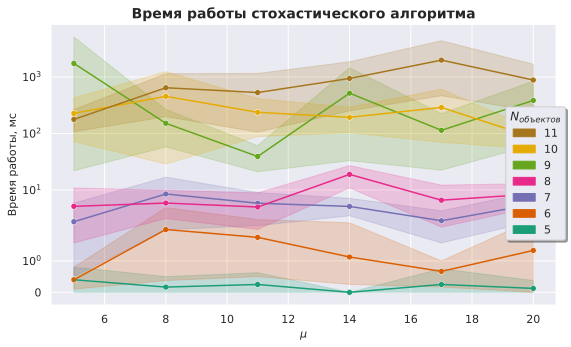

In [211]:
fig, axes = plt.subplots(figsize=(8, 5))
sns.lineplot(data=time_df.reset_index(), x='mu', y='time', hue='n', palette='Dark2', legend=False)
sns.scatterplot(data=meaned.reset_index(), x='mu', y='time', hue='n', palette='Dark2', legend=False)
plt.yscale('symlog')
plt.title('Время работы стохастического алгоритма', weight='bold', fontsize=14)
plt.xlabel('$\mu$', fontsize=11)
plt.ylabel('Время работы, мс', fontsize=11)

colors = np.array(sns.color_palette('Dark2', 7).as_hex())
handles = [mpatches.Patch(color=colors[i], label=f'{i+5}') for i in range(7)][::-1]
fig.legend(handles=handles, title='$N_{объектов}$', fancybox=True, shadow=True, loc='right');

plt.tight_layout()


In [212]:
fig.savefig('../fig/times.pdf', bbox_inches='tight')

In [113]:
pivoted = bins_df.pivot(index='n', columns='mu', values='min_bins').sort_index(ascending=False)
pivoted

mu,5,8,11,14,17,20
n,,,,,,
11,2.350903,2.260919,2.472785,2.592436,2.632763,2.561857
10,2.079870,2.121447,2.115851,2.124508,2.056412,2.014467
9,2.130644,2.086543,2.097955,2.257927,2.071354,2.101090
8,2.043796,2.076253,2.112861,2.190227,2.219231,2.085738
7,2.028381,2.055888,2.150917,2.119737,2.017787,2.077760
6,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
5,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [217]:
new = pivoted - 2 
new = new / new.max()
new = new * 2 + 2.3

Text(0.5, 1.0, 'Средняя значность')

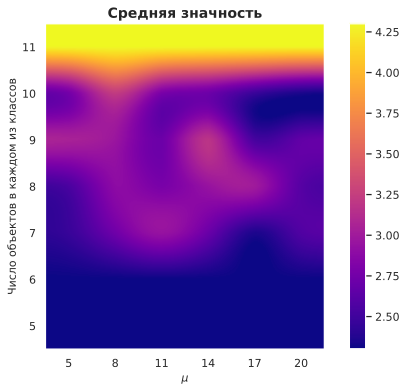

In [218]:
fig, ax = plt.subplots(figsize=(9, 6))
img = ax.imshow(new, interpolation='spline16', cmap='plasma')
plt.colorbar(img, ax=ax)
plt.grid(False)
plt.xlabel('$\mu$', fontsize=11)
plt.yticks(list(range(7)), list(range(5, 12))[::-1])

plt.ylabel('Число объектов в каждом из классов', fontsize=11)
plt.xticks(list(range(6)), np.linspace(5, 20, 6, dtype=int))
ax.set_title('Средняя значность', weight='bold', fontsize=14)

# plt.tight_layout()

In [214]:
fig.savefig('../fig/heatmap.pdf', bbox_inches='tight')